## 0. Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from scipy.stats import boxcox, norm, ks_2samp
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pmdarima'

## 1. Data load

In [ ]:
df_total_payments = pd.read_csv("../Datasets/clean_total_payments.csv", index_col=0)
df_purchase_orders = pd.read_csv("../Datasets/clean_purchase_orders.csv", index_col=0)
df_customer = pd.read_csv("../Datasets/clean_customer.csv", index_col=0)
df_employees = pd.read_csv("../Datasets/clean_employees.csv", index_col=0)
df_inventory = pd.read_csv("../Datasets/clean_inventory.csv", index_col=0)
df_order_details = pd.read_csv("../Datasets/clean_order_details.csv", index_col=0)
df_orders = pd.read_csv("../Datasets/clean_orders.csv", index_col=0)
df_products = pd.read_csv("../Datasets/clean_products.csv", index_col=0)
df_order_payment = pd.read_csv("../Datasets/clean_order_payment.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/clean_total_payments.csv'

In [ ]:
from google.colab import files
uploaded = files.upload()
df_orders = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_orders.head()

Saving clean_orders.csv to clean_orders (1).csv


,OrderID,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
0,2,1,1,1,2003-07-10,2003-07-10,0.0,0,2003,7
1,4,2,2,1,2003-07-11,2003-07-11,0.0,0,2003,7
2,5,2,1,1,2003-07-15,2003-07-15,0.0,0,2003,7
3,6,3,1,1,2003-07-14,2003-07-14,0.0,0,2003,7
4,7,4,1,1,2003-07-14,2003-07-15,0.0,1,2003,7


In [ ]:
uploaded = files.upload()

df_order_details = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_order_details.head()

Saving clean_order_details.csv to clean_order_details (1).csv


,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price
0,2,2,955,5,7.5,37.5
1,3,2,958,5,8.5,42.5
2,5,2,959,5,8.5,42.5
3,6,4,72,50,3.0,150.0
4,7,4,9,50,3.2,160.0


In [ ]:
uploaded = files.upload()
df_products = pd.read_csv(next(iter(uploaded)), index_col= 0)
df_products.head()

Saving clean_products.csv to clean_products (1).csv


,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,2003-07-10,6.6,182
1,2,3-183,AT,Undershirts,Girls' Undershirts,Underwear,620,M,Dozen,Out of Production,2003-07-10,5.6,183
2,3,3-184,AT,Undershirts,Girls' Undershirts,Underwear,718,M,Dozen,In Production,2003-07-10,6.3,184
3,4,3-185,AT,Undershirts,Boys' Undershirts,Underwear,820,M,Dozen,In Production,2003-07-10,5.6,185
4,5,3-A30N,A,Briefs,Girls' Panties,Underwear,214,M,Dozen,Out of Production,2003-08-06,3.3,A30N


In [ ]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [ ]:
# Convert date to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.dtypes

,0
OrderDetailID,int64
OrderID,int64
ProductID,int64
QuantitySold,int64
UnitSalesPrice,float64
total_price,float64
CustomerID,int64
EmployeeID,int64
ShippingMethodID,int64
OrderDate,datetime64[ns]


In [ ]:
sales = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [ ]:
sales = sales.set_index('OrderDate')
sales = sales.asfreq('W-MON')

#Interpolacion de los valores faltantes
sales['QuantitySold'] = sales['QuantitySold'].interpolate()
sales

,QuantitySold
OrderDate,
2003-07-14,768.0
2003-07-21,180.0
2003-07-28,614.0
2003-08-04,573.0
2003-08-11,375.0
...,...
2006-03-20,46.0
2006-03-27,25.0
2006-04-03,1080.0


In [ ]:
y = sales['QuantitySold']
y

,QuantitySold
OrderDate,
2003-07-14,768.0
2003-07-21,180.0
2003-07-28,614.0
2003-08-04,573.0
2003-08-11,375.0
...,...
2006-03-20,46.0
2006-03-27,25.0
2006-04-03,1080.0


In [ ]:
mean_value = sales['QuantitySold'].mean()
mean_value

1004.5068965517241

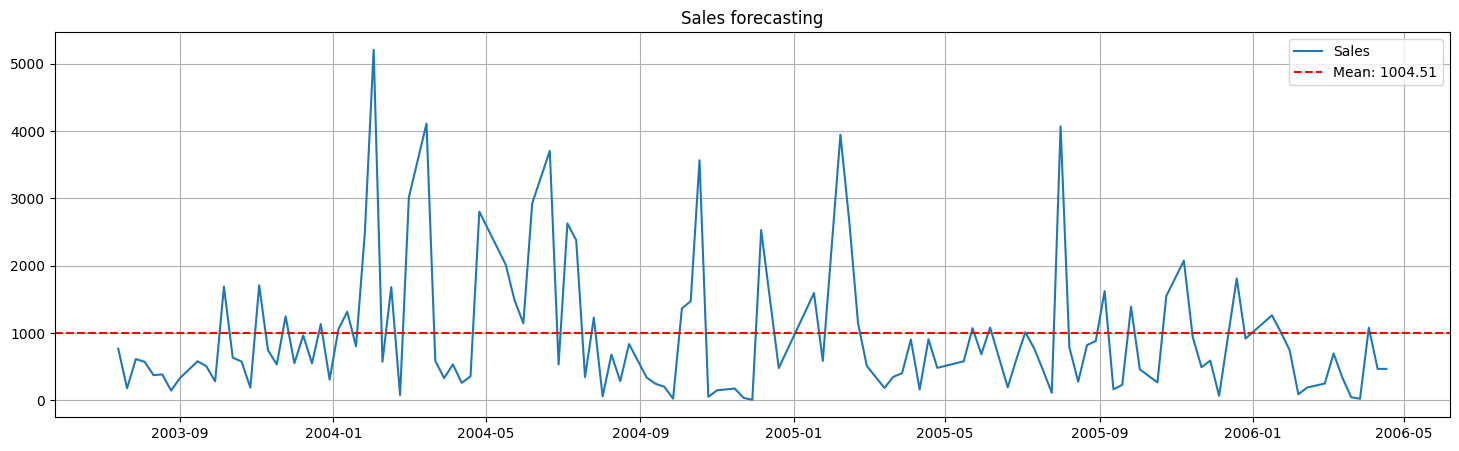

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

<Axes: ylabel='QuantitySold'>

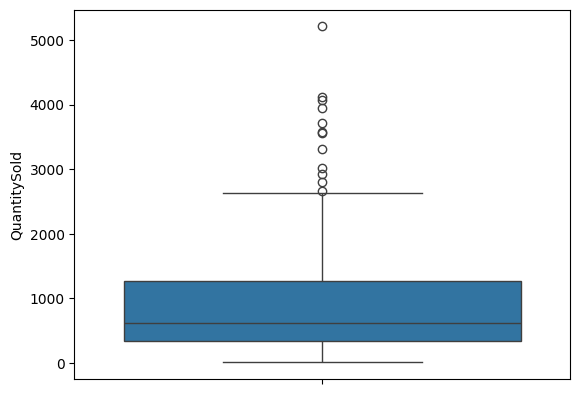

In [ ]:
#estudio de valores atipicos
sns.boxplot(sales['QuantitySold'])

In [ ]:
q1 = sales['QuantitySold'].quantile(0.25)
q3 = sales['QuantitySold'].quantile(0.75)

iqr = q3-q1

lim_inf = q1 - 1.5*iqr
lim_sup = q3 + 1.5*iqr

outliers = sales[(sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup)]

perc_out = (len(outliers) / len(sales['QuantitySold'])) * 100

print(f'Percentage outliers:  {perc_out}')



Percentage outliers:  8.275862068965518


In [ ]:
sales['QuantitySold'].median(), sales['QuantitySold'].mean()

(620.0, 1004.5068965517241)

In [ ]:
# sustituimos los valores atipicos por la mediana

sales['QuantitySold_no_out'] = np.where((sales['QuantitySold'] < lim_inf) | (sales['QuantitySold'] > lim_sup),
                              sales['QuantitySold'].mean(), sales['QuantitySold'])

In [ ]:
sales

,QuantitySold,QuantitySold_no_out
OrderDate,,
2003-07-14,768.0,768.0
2003-07-21,180.0,180.0
2003-07-28,614.0,614.0
2003-08-04,573.0,573.0
2003-08-11,375.0,375.0
...,...,...
2006-03-20,46.0,46.0
2006-03-27,25.0,25.0
2006-04-03,1080.0,1080.0


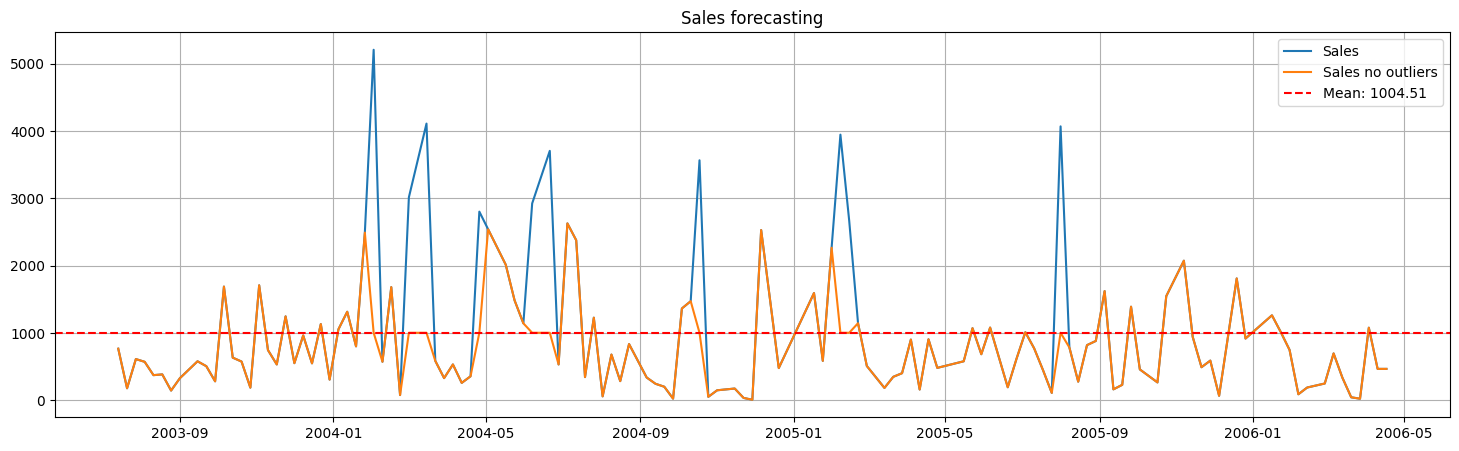

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(sales['QuantitySold'], linestyle="-", label = 'Sales')
plt.plot(sales['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sales['QuantitySold'] = sales['QuantitySold_no_out']
sales.drop(columns=['QuantitySold_no_out'], inplace=True)

In [ ]:
from scipy.stats import norm


p-value Kolmogorov-Smirnov: 2.147655317497006e-86
p-value Shapiro-Wilk: 3.9454963638867794e-08


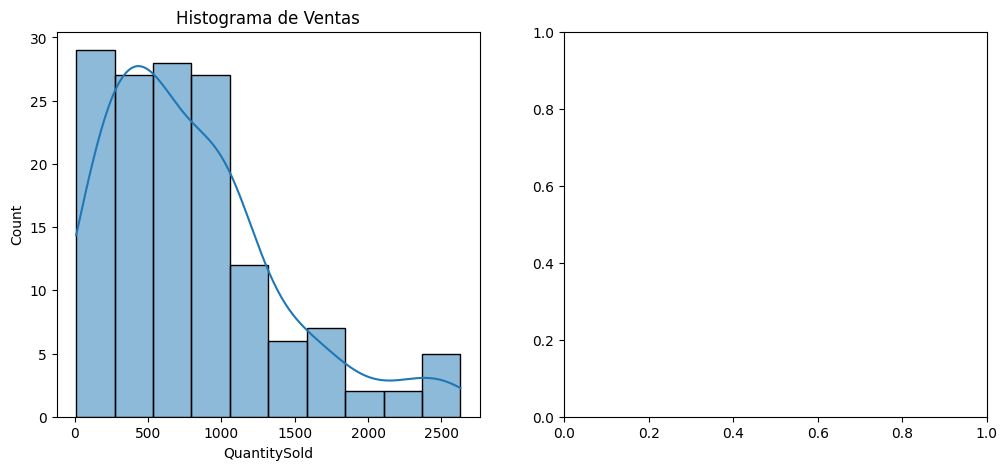

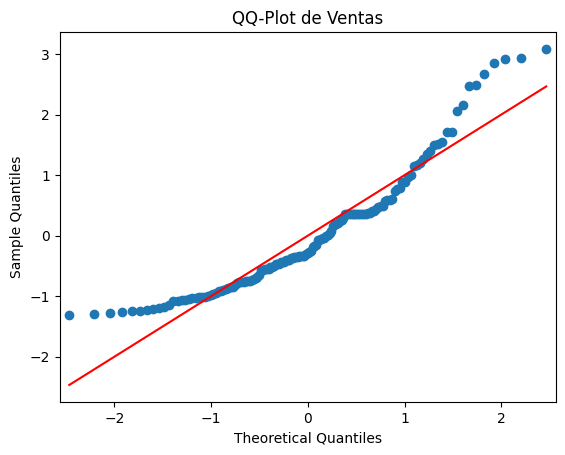

La serie NO es normal. Aplicando Box-Cox...
Lambda de Box-Cox: 0.3884595304899592


In [ ]:
# comprobar la normalidad

from scipy.stats import shapiro, ks_2samp


residuos = sales['QuantitySold']

# Test de Kolmogorov-Smirnov
ks_stat, p_ks = ks_2samp(residuos, norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(residuos) if len(residuos) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(residuos, kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

# Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
    print("La serie NO es normal. Aplicando Box-Cox...")
    sales['QuantitySold'] = sales['QuantitySold'] + 1e-6
    sales['QuantitySold'], lambda_bc = boxcox(sales['QuantitySold'])
    print(f"Lambda de Box-Cox: {lambda_bc}")
else:
    print("La serie es normal. No es necesario aplicar Box-Cox.")


p-value Kolmogorov-Smirnov: 2.147655317497006e-86
p-value Shapiro-Wilk: 0.4433260810305538


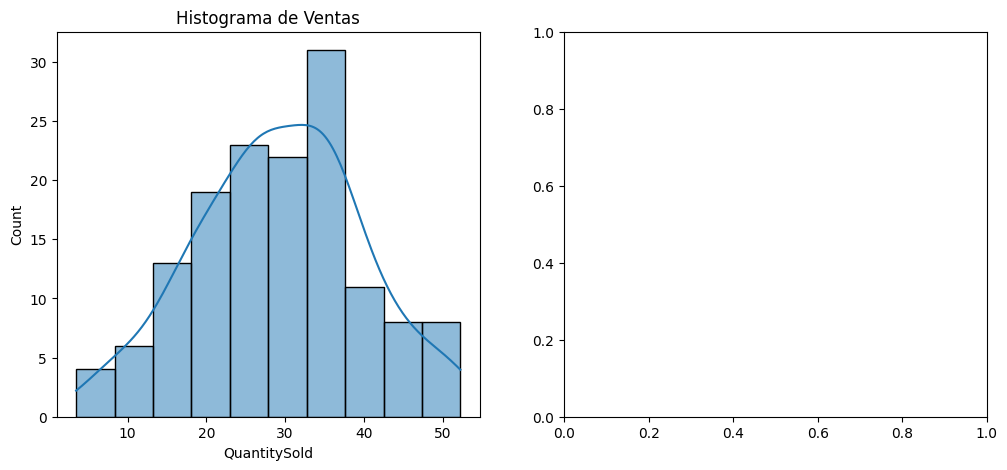

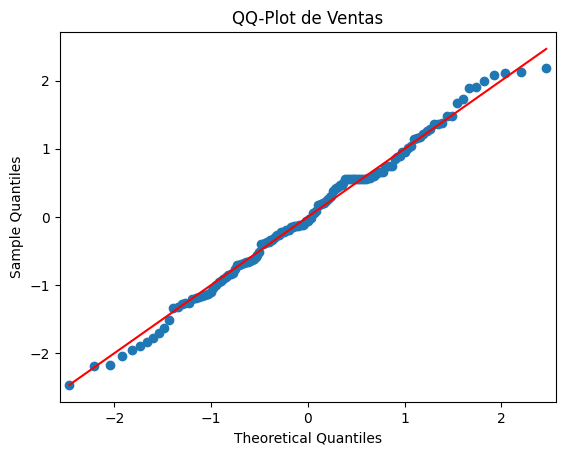

In [ ]:
ks_stat, p_ks = ks_2samp(sales['QuantitySold'], norm.rvs(size=len(residuos)))
# Test de Shapiro-Wilk (para n < 5000)
shapiro_stat, p_shapiro = shapiro(sales['QuantitySold']) if len(sales['QuantitySold']) < 5000 else (None, None)

print(f"p-value Kolmogorov-Smirnov: {p_ks}")
print(f"p-value Shapiro-Wilk: {p_shapiro}")

# Histograma y QQ-Plot para ver distribución
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(sales['QuantitySold'], kde=True)
plt.title("Histograma de Ventas")

plt.subplot(122)
sm.qqplot(sales['QuantitySold'], line='s', fit=True)
plt.title("QQ-Plot de Ventas")
plt.show()

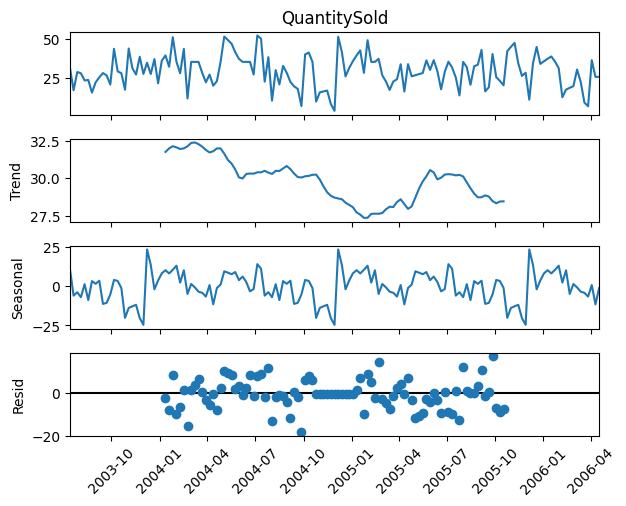

In [ ]:
# descomposicion de la serie temporal

descomposicion = sm.tsa.seasonal_decompose(sales['QuantitySold'], model='additive')
descomposicion.plot()
plt.xticks(rotation = 45)
plt.show()

- la tendencia sugiere que hay un cambio sistemático a lo largo del tiempo

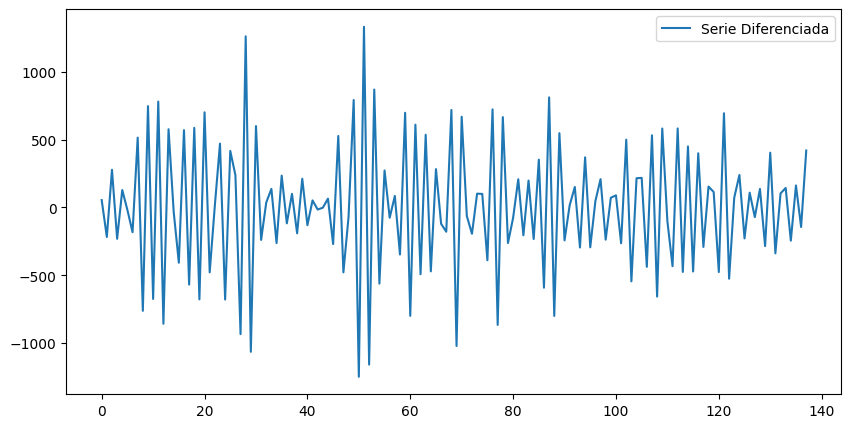

p-value ADF: 5.2445090733437e-16


In [ ]:
# diferencia estacional

sales_diff = np.diff(sales['QuantitySold'], 7)
plt.figure(figsize=(10,5))
plt.plot(sales_diff, label="Serie Diferenciada")
plt.legend()
plt.show()

# Test de estacionariedad (ADF)
adf_test = adfuller(sales_diff)
print(f"p-value ADF: {adf_test[1]}") # es estacionaria

Explicación del análisis espectral:
- Análisis espectral: El análisis espectral te ayuda a identificar las frecuencias dominantes presentes en una serie temporal. Básicamente, te dice qué patrones repetitivos (frecuencias) hay en tus datos, lo cual es muy útil cuando se sospecha que la serie temporal tiene comportamientos periódicos o cíclicos.

- Periodograma: El periodograma es una forma de visualización que te muestra la potencia de las distintas frecuencias en los datos. En este caso, ax.psd(sales['QuantitySold'], NFFT=256) está calculando el espectro de potencia de la serie temporal sales['QuantitySold'].

Eje X: Frecuencia (en unidades de ciclos por muestra).
Eje Y: Potencia de la frecuencia. Cuanto más alta es la potencia en una frecuencia determinada, más fuerte es ese patrón cíclico en los datos.
Parámetro NFFT=256:

NFFT (Número de puntos para la transformada rápida de Fourier) es el número de puntos de datos utilizados para calcular el análisis espectral. En este caso, NFFT=256 significa que se usa una ventana de 256 puntos para calcular las frecuencias. El valor de NFFT puede afectar la resolución de las frecuencias.

    ¿Qué te dice el periodograma?

Si hay picos prominentes en el gráfico, esto sugiere que hay una frecuencia dominante en los datos. Estos picos indican que hay un patrón periódico que se repite con cierta regularidad.

Si los datos son aleatorios o no tienen una frecuencia cíclica clara, entonces el periodograma debería verse relativamente plano, sin picos significativos.

Ejemplo:

Si se observa un pico en una frecuencia baja (cerca del origen), eso sugiere que hay un patrón cíclico largo. Esto podría ser útil si las ventas siguen un patrón estacional a largo plazo (por ejemplo, ventas más altas en ciertos meses del año).
Si el pico está en una frecuencia más alta, podría indicar que hay un patrón más corto o diario en los datos, como fluctuaciones diarias en las ventas.

Cómo interpretar:
Si encuentras un pico claro en el gráfico:
Ubicación del pico: La frecuencia en la que aparece te dirá qué tan rápido se repite el patrón.
Altura del pico: Cuanto más alto es el pico, más importante o prominente es esa frecuencia en los datos.
Si no encuentras picos significativos y el gráfico es relativamente plano, eso sugiere que no hay patrones cíclicos o regulares claros en los datos y que los datos pueden ser más aleatorios.
¿Qué hacer con los resultados?
Si encuentras frecuencias dominantes (picos), puedes:

Identificar patrones y ajustar modelos de pronóstico con estacionalidad.
Detectar ciclos (por ejemplo, semanal, mensual, anual) y ajustar tus modelos en consecuencia.

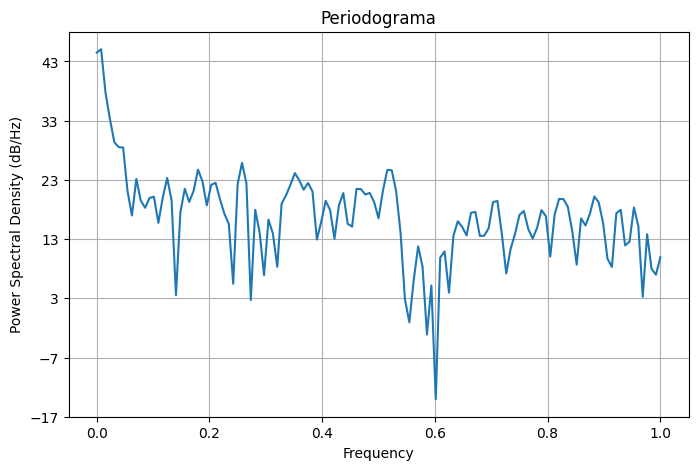

In [ ]:
# análisis espectral
fig, ax = plt.subplots(figsize=(8, 5))
ax.psd(sales['QuantitySold'], NFFT=256)
plt.title("Periodograma")
plt.show()

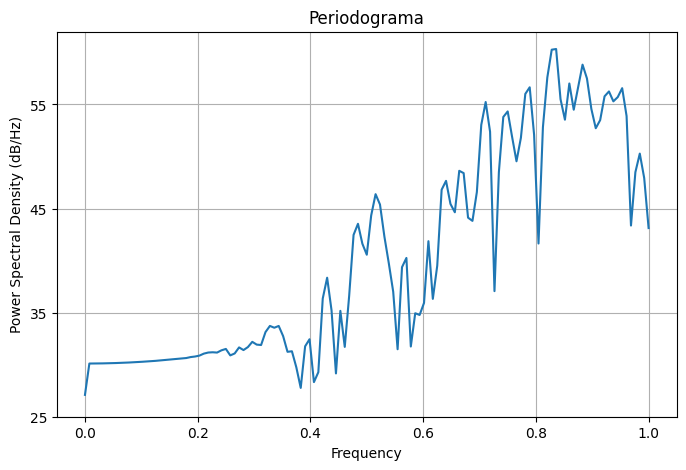

In [ ]:
# análisis espectral
fig, ax = plt.subplots(figsize=(8, 5))
ax.psd(sales_diff, NFFT=256)
plt.title("Periodograma")
plt.show()

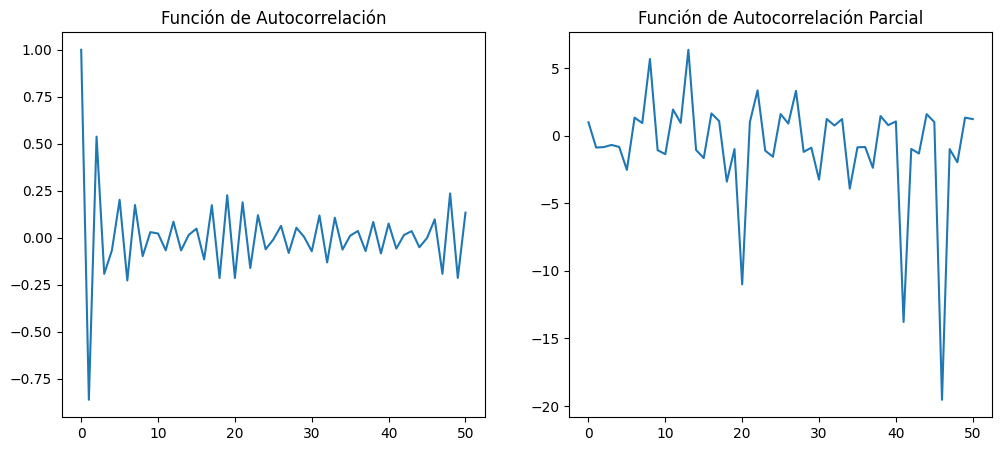

In [ ]:
# FAS y FAP

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(acf(sales_diff, nlags=50))
plt.title("Función de Autocorrelación")

plt.subplot(122)
plt.plot(pacf(sales_diff, nlags=50))
plt.title("Función de Autocorrelación Parcial")

plt.show()

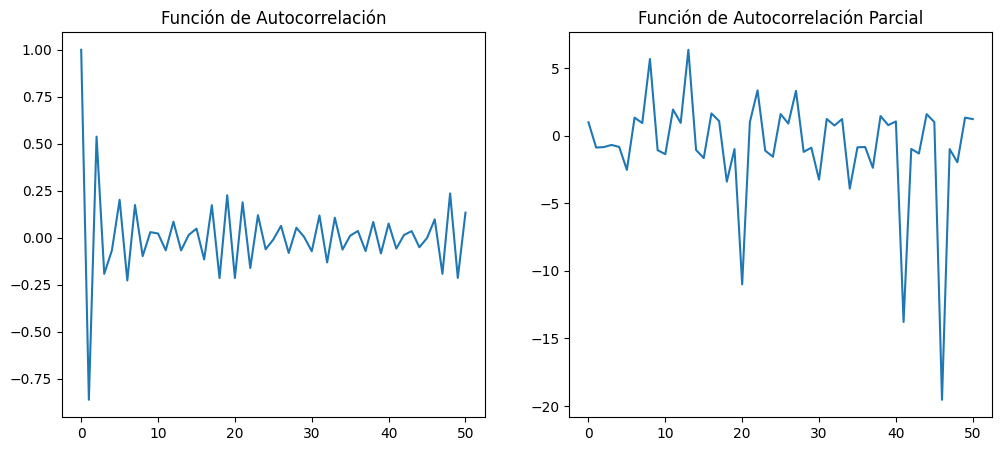

In [ ]:
# FAS y FAP

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(acf(sales_diff, nlags=50))
plt.title("Función de Autocorrelación")

plt.subplot(122)
plt.plot(pacf(sales_diff, nlags=50))
plt.title("Función de Autocorrelación Parcial")

plt.show()

In [ ]:
# seleccion del modelo ARIMA

modelo_autoarima = auto_arima(sales['QuantitySold'], seasonal=True, m=12, trace=True, suppress_warnings=True)

print(f"Mejor modelo sugerido por auto_arima: {modelo_autoarima.order}, {modelo_autoarima.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1097.172, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1089.256, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1090.943, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1410.477, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1087.255, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1089.253, Time=0.80 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1091.252, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1088.757, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1088.686, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1089.027, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1090.750, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=1146.209, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.650 seconds
Mejor modelo 

In [ ]:
modelo_sarima = sm.tsa.SARIMAX(sales['QuantitySold'],
                               order=(1, 0, 0),
                               seasonal_order=(0, 0, 0, 12),
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()

print(modelo_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:           QuantitySold   No. Observations:                  145
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -566.238
Date:                Thu, 20 Feb 2025   AIC                           1136.476
Time:                        19:09:28   BIC                           1142.415
Sample:                    07-14-2003   HQIC                          1138.889
                         - 04-17-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9168      0.039     23.807      0.000       0.841       0.992
sigma2       152.4044     13.780     11.059      0.000     125.395     179.414
Ljung-Box (L1) (Q):                  22.61   Jarque-

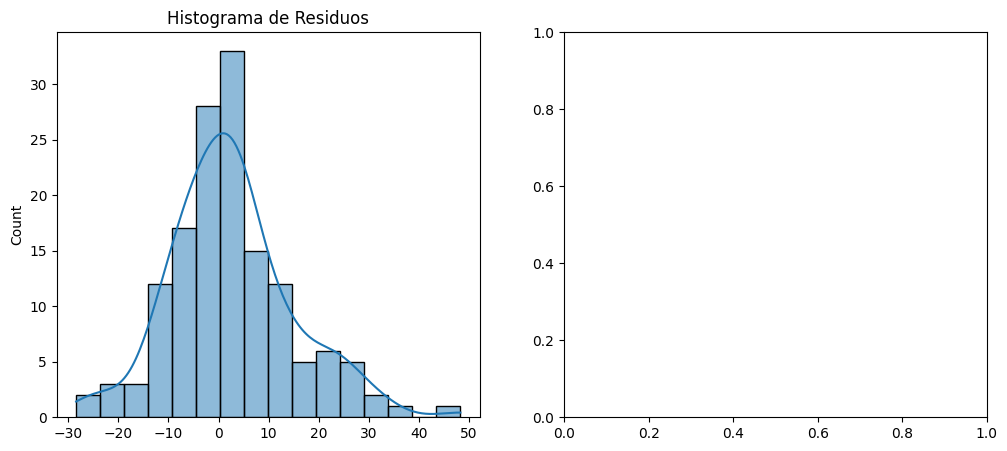

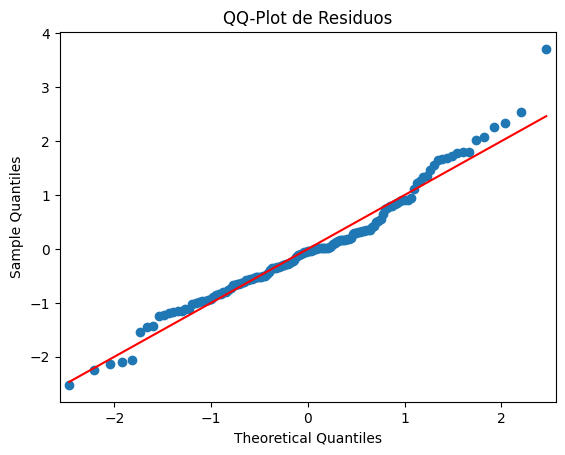

In [ ]:
# Residuos
residuos = modelo_sarima.resid

# Normalidad
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.histplot(residuos, kde=True)
plt.title("Histograma de Residuos")

plt.subplot(122)
sm.qqplot(residuos, line='s', fit=True)
plt.title("QQ-Plot de Residuos")
plt.show()

p-value ADF (Estacionariedad): 3.317121895397716e-11
p-value Ljung-Box (Independencia): lb_pvalue
p-value Kolmogorov-Smirnov (Normalidad): 4.462716755273771e-17
p-value Breusch-Pagan (Homocedasticidad): 0.5077194375345313


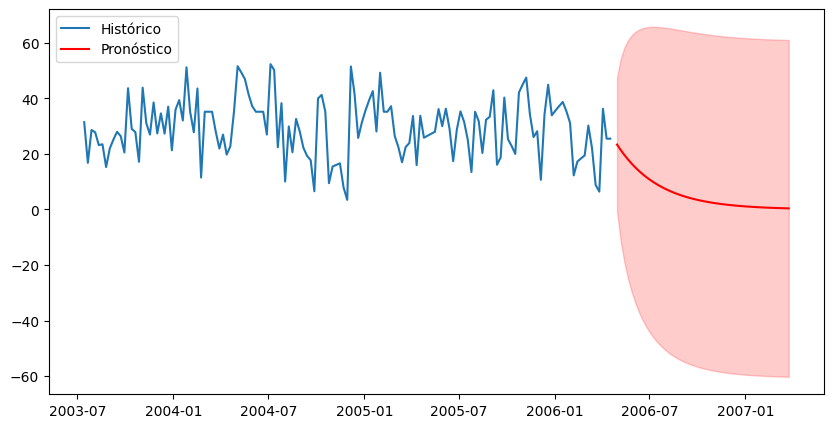

In [ ]:
# Pruebas estadísticas
_, p_adf, _, _, _, _ = adfuller(residuos)
_, p_ljung = sm.stats.acorr_ljungbox(residuos, lags=[24])
_, p_norm = ks_2samp(residuos, norm.rvs(size=len(residuos)))

print(f"p-value ADF (Estacionariedad): {p_adf}")
print(f"p-value Ljung-Box (Independencia): {p_ljung}")
print(f"p-value Kolmogorov-Smirnov (Normalidad): {p_norm}")

# Homocedasticidad (Breusch-Pagan)
regressor = np.arange(len(residuos))
_, p_bp, _, _ = het_breuschpagan(residuos, sm.add_constant(regressor))
print(f"p-value Breusch-Pagan (Homocedasticidad): {p_bp}")

# --------------------------- PREDICCIONES ---------------------------

forecast = modelo_sarima.get_forecast(steps=48)
pred_ci = forecast.conf_int()

plt.figure(figsize=(10,5))
plt.plot(sales['QuantitySold'], label="Histórico")
plt.plot(pd.date_range(start=sales['QuantitySold'].index[-1], periods=49, freq='W')[1:],
         forecast.predicted_mean, label="Pronóstico", color='red')
plt.fill_between(pd.date_range(start=sales['QuantitySold'].index[-1], periods=49, freq='W')[1:],
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.show()